In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 40.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [3]:
import os
import cv2
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import mediapipe as mp
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model

In [4]:
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/Cricket Dataset

Mounted at /content/drive


In [5]:
# Define paths
DATASET_DIR = '/content/drive/MyDrive/Cricket Dataset/'
CLASSES_LIST = ['cover', 'defense', 'flick', 'hook', 'lofted', 'pull']
SEQUENCE_LENGTH = 20  # Adjust based on your videos
# Define constants
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

In [6]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

In [8]:
def frames_extraction(video_path):
    frames_list = []
    pose_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

        # Extract pose
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)
        if result.pose_landmarks:
            pose_keypoints = np.array([[lm.x, lm.y, lm.z] for lm in result.pose_landmarks.landmark]).flatten()
        else:
            pose_keypoints = np.zeros(33 * 3)  # 33 key points with x, y, z
        pose_list.append(pose_keypoints)

    video_reader.release()
    return frames_list, pose_list


In [9]:
def create_dataset():
    features = []
    pose_features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames, poses = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH and len(poses) == SEQUENCE_LENGTH:
                features.append(frames)
                pose_features.append(poses)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    pose_features = np.asarray(pose_features)
    labels = np.array(labels)
    return features, pose_features, labels, video_files_paths


In [10]:
# Create the dataset
features, pose_features, labels, video_files_paths = create_dataset()


Extracting Data of Class: cover


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Extracting Data of Class: defense
Extracting Data of Class: flick
Extracting Data of Class: hook
Extracting Data of Class: lofted
Extracting Data of Class: pull


In [11]:
# Convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)


In [12]:
# Split the dataset into training and test sets
features_train, features_test, pose_features_train, pose_features_test, labels_train, labels_test = train_test_split(
    features, pose_features, one_hot_encoded_labels, test_size=0.2, random_state=42
)

In [13]:
def create_convlstm_model():
    frames_input = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='frames_input')
    pose_input = Input(shape=(SEQUENCE_LENGTH, 33 * 3), name='pose_input')

    x = ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                   recurrent_dropout=0.2, return_sequences=True)(frames_input)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = TimeDistributed(Dropout(0.2))(x)

    x = ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                   recurrent_dropout=0.2, return_sequences=True)(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = TimeDistributed(Dropout(0.2))(x)

    x = ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                   recurrent_dropout=0.2, return_sequences=True)(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = TimeDistributed(Dropout(0.2))(x)

    x = ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                   recurrent_dropout=0.2, return_sequences=True)(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)

    x = Flatten()(x)

    y = Flatten()(pose_input)

    combined = Concatenate()([x, y])

    output = Dense(len(CLASSES_LIST), activation="softmax")(combined)

    model = Model(inputs=[frames_input, pose_input], outputs=output)

    model.summary()
    return model


In [14]:
# Construct the convlstm model
convlstm_model = create_convlstm_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frames_input (InputLayer)   [(None, 20, 64, 64, 3)]      0         []                            
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)        1024      ['frames_input[0][0]']        
                                                                                                  
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)        0         ['conv_lstm2d[0][0]']         
 D)                                                                                               
                                                                                                  
 time_distributed (TimeDist  (None, 20, 31, 31, 4)        0         ['max_pooling3d[0][0]']   

In [15]:
# Create an instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)


In [16]:
# Compile the model
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])


In [17]:
# Start training the model
convlstm_model_training_history = convlstm_model.fit(
    x={'frames_input': features_train, 'pose_input': pose_features_train},
    y=labels_train,
    epochs=50,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
179/179 [==============================] - 44s 174ms/step - loss: 1.7880 - accuracy: 0.2737 - val_loss: 1.4388 - val_accuracy: 0.3966
Epoch 2/50
179/179 [==============================] - 30s 166ms/step - loss: 1.4191 - accuracy: 0.4413 - val_loss: 1.3831 - val_accuracy: 0.4749
Epoch 3/50
179/179 [==============================] - 29s 164ms/step - loss: 1.2909 - accuracy: 0.4930 - val_loss: 1.4292 - val_accuracy: 0.4469
Epoch 4/50
179/179 [==============================] - 30s 165ms/step - loss: 1.1265 - accuracy: 0.5712 - val_loss: 1.2906 - val_accuracy: 0.5307
Epoch 5/50
179/179 [==============================] - 29s 165ms/step - loss: 1.0396 - accuracy: 0.6131 - val_loss: 1.3037 - val_accuracy: 0.5363
Epoch 6/50
179/179 [==============================] - 29s 163ms/step - loss: 0.9517 - accuracy: 0.6327 - val_loss: 1.3562 - val_accuracy: 0.4525
Epoch 7/50
179/179 [==============================] - 29s 164ms/step - loss: 0.8735 - accuracy: 0.6634 - val_loss: 1.5482 - val_ac

In [18]:
# Evaluate the trained model
model_evaluation_history = convlstm_model.evaluate(
    x={'frames_input': features_test, 'pose_input': pose_features_test},
    y=labels_test
)

7/7 [==============================] - 1s 46ms/step - loss: 1.3063 - accuracy: 0.5491


In [19]:
# Get the loss and accuracy from model_evaluation_history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history


In [20]:
# Define the string date format
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)



In [21]:
# Define a useful name for our model
model_file_name = f'convlstm_model_with_pose___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss:.2f}___Accuracy_{model_evaluation_accuracy:.2f}.h5'

# Save the model
convlstm_model.save(model_file_name)

# Display the success message
print(f"Model Created Successfully and saved as {model_file_name}!")



Model Created Successfully and saved as convlstm_model_with_pose___Date_Time_2024_07_11__10_06_15___Loss_1.31___Accuracy_0.55.h5!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Define the function to plot the metrics
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, x_label='Epochs', y_label='Value', save_as_file=False):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
    plt.title(str(plot_name))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    if save_as_file:
          plt.savefig(f'{plot_name}.png')
    plt.show()


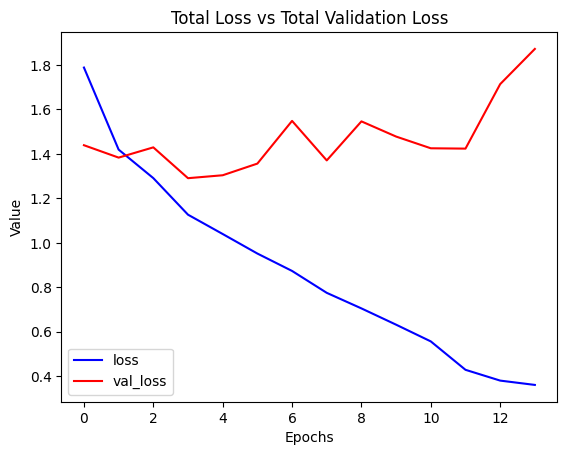

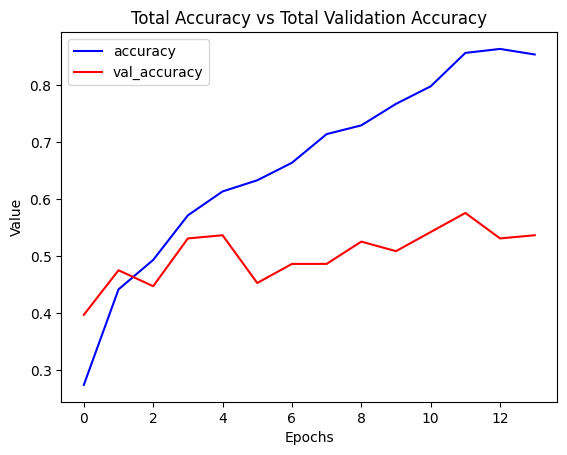

In [31]:
# Visualize the training and validation loss metrics
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss', save_as_file=True)
# Visualize the training and validation accuracy metrics
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy', save_as_file=True)


In [24]:
# Evaluate the model on the validation set
y_pred = convlstm_model.predict(x={'frames_input': features_test, 'pose_input': pose_features_test})
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(labels_test, axis=1)

7/7 [==============================] - 1s 42ms/step


In [25]:
# Print the classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASSES_LIST))


              precision    recall  f1-score   support

       cover       0.38      0.15      0.22        39
     defense       0.85      0.78      0.81        45
       flick       0.82      0.53      0.65        43
        hook       0.41      0.52      0.45        29
      lofted       0.72      0.69      0.71        42
        pull       0.24      0.58      0.34        26

    accuracy                           0.55       224
   macro avg       0.57      0.54      0.53       224
weighted avg       0.61      0.55      0.56       224



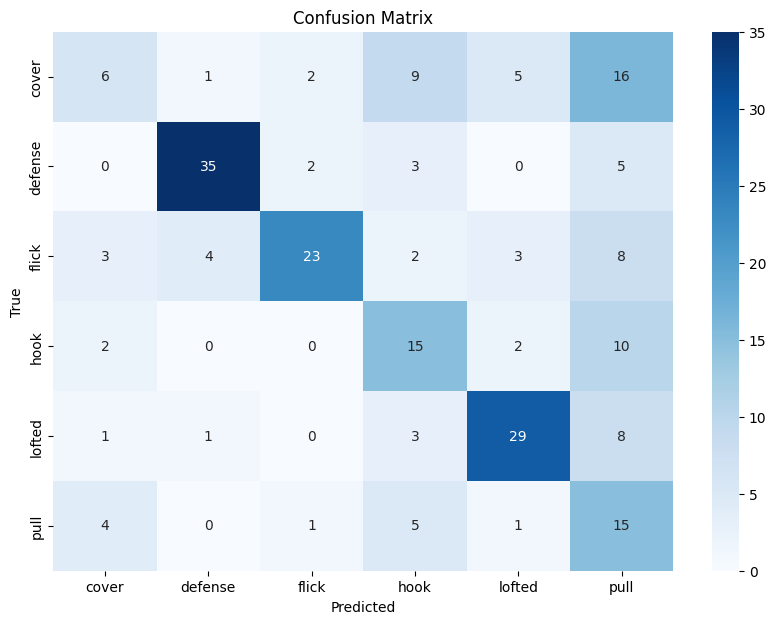

In [26]:
# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/content/confusion_matrix.png')
plt.show()